<a href="https://colab.research.google.com/github/OtusTeam/Machine-Learning/blob/main/%D0%9C%D0%BE%D0%B4%D1%83%D0%BB%D1%8C%207%3A%20Bayesian%20Learning%2C%20PyMC/37_01_Ridge_Log_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1, style='whitegrid', palette='Set1')

red = '#FF3300'
blue = '#0099CC'
green = '#00CC66'

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, ARDRegression
from sklearn.datasets import make_regression

## Подходы к Ridge-регрессии

### Оптимизационный (`Ridge`)

Решается задача

$\left\lVert y - X\theta \right\rVert^2_2 + \alpha \left\lVert \theta\right\rVert^2_2 \longrightarrow \min\limits_\theta$

`sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver=’auto’, random_state=None)`
* `alpha` -- параметр регуляризации;
* `fit_intercept` -- добавить ли в модель константный признак;
* `max_iter`, `tol`, `solver` -- параметры, отвечающие за метод оптимизации. Приближенная оптимизация позволяет избежать проблем при обращении больших матриц.

Обученные параметры:
* `coef_` -- коэффициенты перед признаками;
* `intercept_` -- свободный коэффициент.



### Байесовский (`BayesianRidge`)

Делаются следующе предположения:

$Y \sim \mathcal{N}(X\theta, \alpha)$ -- распределение данных;

$\theta \sim \mathcal{N}(0, \lambda^{-1} I_d)$ -- априорное распределение на вектор коэффициентов;

$\alpha \sim \Gamma(\alpha_2, \alpha_1)$ -- априорное распределение на дисперсию шума;

$\lambda \sim \Gamma(\lambda_2, \lambda_1)$ -- априорное распределение на дисперсию коэффициентов.

При обучении модели вычисляется мода совместного распределения на параметры $\theta, \alpha, \lambda$.

`sklearn.linear_model.BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, compute_score=False, fit_intercept=True, normalize=False, copy_X=True, verbose=False)`
* `alpha_1` и `alpha_2` -- параметр априорного распределения на $\alpha$;
* `lambda_1` и `lambda_2` -- параметр априорного распределения на $\lambda$;
* `fit_intercept` -- добавить ли в модель константный признак;
* `n_iter`, `tol`, `solver` -- параметры, отвечающие за оптимизацию;
* `compute_score` -- вычислять ли логарифм оптимизируемого функционала на каждой итерации;
* `verbose` -- печатать информацию о процессе обучения.

Обученные параметры:
* `coef_` -- коэффициенты перед признаками;
* `sigma_` -- оценка матрицы ковариаций на коэффициенты перед признаками;
* `intercept_` -- свободный коэффициент;
* `alpha_` и `lambda_` -- оценки параметров $\alpha$ и $\lambda$;
-------------------

Сгенерируем данные по правилу $Y_i = 1 + \frac{1}{2}X_i + \varepsilon_i$, где $\varepsilon_i \sim \mathcal{N}(0, 1)$

In [ ]:
n = 50
theta = np.array([1, 1/2])

X = sps.uniform(loc=-2, scale=4).rvs(size=n)
Y = theta[0] + theta[1] * X + sps.norm(scale=1).rvs(size=n)

Обучение модели $y(x) = \theta_0 + \theta_1 x$ байесовской ридж-регрессией

In [ ]:
model = BayesianRidge(compute_score=True, fit_intercept=True)
model.fit(X.reshape((-1, 1)), Y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

Оценки коэффициентов

In [ ]:
model.coef_, model.intercept_

(array([0.4625947]), 1.0887054634948667)

Оценка матрицы ковариаций

In [ ]:
model.sigma_

array([[0.01622702]])

Оценки параметров

In [ ]:
model.alpha_, model.lambda_

(0.9641031522067065, 4.343557179983254)

Количество проведенных итераций

In [ ]:
model.n_iter_

4

Процесс оптимизации

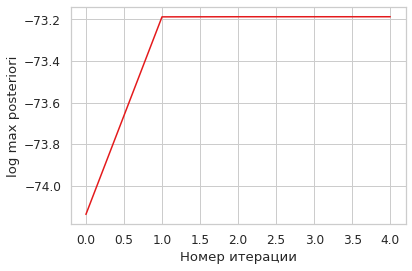

In [ ]:
plt.plot(model.scores_)
plt.xlabel('Номер итерации')
plt.ylabel('log max posteriori');

Построим график предсказаний и предсказательного интервала

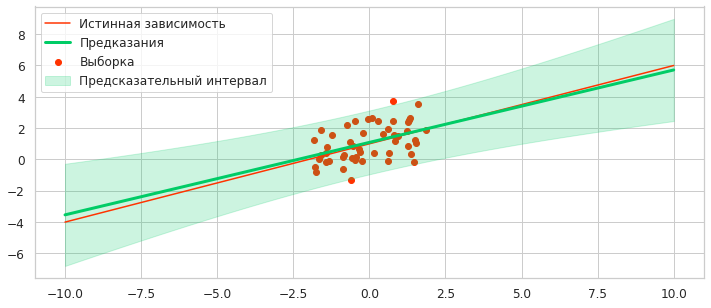

In [ ]:
grid = np.linspace(-10, 10, 100)
means, stds = model.predict(grid.reshape((-1, 1)), return_std=True)

plt.figure(figsize=(12, 5))
plt.scatter(X, Y, label='Выборка', color=red)
plt.plot(grid, theta[0] + theta[1] * grid, 
         label='Истинная зависимость', color=red)
plt.plot(grid, means, label='Предказания', color=green, lw=3)
plt.fill_between(grid, means - 2*stds, means + 2*stds, 
                 alpha=0.2, label='Предсказательный интервал', color=green)
plt.legend();

Совершим аналогичные действия с моделью $y(x) = \theta_0 + \theta_1 x\sin x$ байесовской ридж-регрессией

In [ ]:
n = 50
theta = np.array([1, 2])

X = sps.laplace(loc=0, scale=3).rvs(size=n)
Y = theta[0] + theta[1] * X * np.sin(X) + sps.norm(scale=3).rvs(size=n)

model = BayesianRidge(compute_score=True)
model.fit((X * np.sin(X)).reshape((-1, 1)), Y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

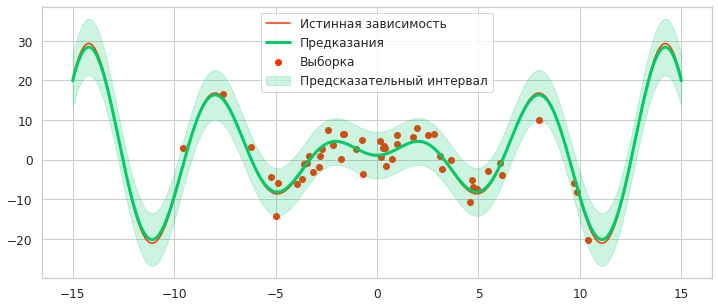

In [ ]:
grid = np.linspace(-15, 15, 1000)
means, stds = model.predict((grid * np.sin(grid)).reshape((-1, 1)), 
                            return_std=True)

plt.figure(figsize=(12, 5))
plt.scatter(X, Y, label='Выборка', color=red)
plt.plot(grid, theta[0] + theta[1] * grid * np.sin(grid), 
         label='Истинная зависимость', color=red)
plt.plot(grid, means, label='Предказания', color=green, lw=3)
plt.fill_between(grid, means - 2*stds, means + 2*stds, 
                 alpha=0.2, label='Предсказательный интервал', color=green)
plt.legend();

## ARDRegression -- метод релевантных векторов

Делаются следующе предположения:

$Y \sim \mathcal{N}(X\theta, \alpha)$ -- распределение данных;

$\theta \sim \mathcal{N}(0, \lambda^{-1} I_d)$ -- априорное распределение на вектор коэффициентов;

$\alpha \sim \Gamma(\alpha_2, \alpha_1)$ -- априорное распределение на дисперсию шума;

$\lambda \sim \Gamma(\lambda_2, \lambda_1)$ -- априорное распределение на дисперсию коэффициентов.

Параметры модели подбираются по принципу максимизации обоснованности.

`sklearn.linear_model.ARDRegression(n_iter=300, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, compute_score=False, threshold_lambda=10000.0, fit_intercept=True, normalize=False, copy_X=True, verbose=False)`
* `alpha_1` и `alpha_2` -- параметр априорного распределения на $\alpha$;
* `lambda_1` и `lambda_2` -- параметр априорного распределения на $\lambda$;
* `fit_intercept` -- добавить ли в модель константный признак;
* `threshold_lambda` -- пороговое значение дисперсии (обратной к ней), при которой коэффициент зануляется;
* `n_iter`, `tol`, `solver` -- параметры, отвечающие за оптимизацию;
* `compute_score` -- вычислять ли логарифм оптимизируемого функционала на каждой итерации;
* `verbose` -- печатать информацию о процессе обучения.

Обученные параметры:
* `coef_` -- коэффициенты перед признаками;
* `sigma_` -- оценка матрицы ковариаций на коэффициенты перед признаками;
* `intercept_` -- свободный коэффициент;
* `alpha_` и `lambda_` -- оценки параметров $\alpha$ и $\lambda$;
-------------------

Сгенерируем данные по правилу $Y_i = 1 + 2X_i + \varepsilon_i$, где $\varepsilon_i \sim \mathcal{N}(0, 1)$

In [ ]:
n = 50
theta = np.array([1, 1/2])

X = sps.uniform(loc=-2, scale=4).rvs(size=n)
Y = theta[0] + theta[1] * X + sps.norm(scale=1).rvs(size=n)

Обучение модели $y(x) = \theta_0 + \theta_1 x$ ARD-регрессией

In [ ]:
model = ARDRegression()
model.fit(X.reshape((-1, 1)), Y)

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, threshold_lambda=10000.0, tol=0.001,
              verbose=False)

Оценки коэффициентов

In [ ]:
model.coef_, model.intercept_

(array([0.4301994]), 1.2320590030448384)

Оценка матрицы ковариаций

In [ ]:
model.sigma_

array([[0.01745684]])

Оценки параметров

In [ ]:
model.alpha_, model.lambda_

(0.7602641765097892, array([4.93736244]))

Построим график предсказаний и предсказательного интервала

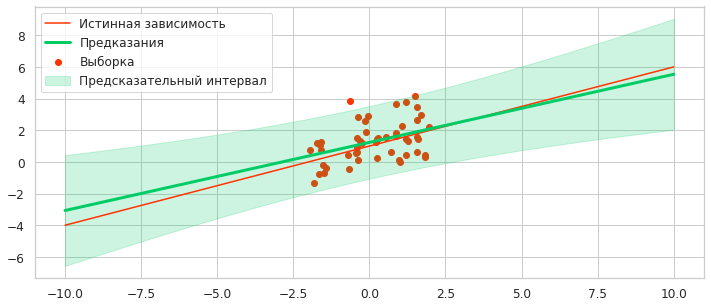

In [ ]:
grid = np.linspace(-10, 10, 100)
means, stds = model.predict(grid.reshape((-1, 1)), return_std=True)

sns.set(font_scale=1.1, style='whitegrid', palette='Set1')
plt.figure(figsize=(12, 5))
plt.scatter(X, Y, label='Выборка', color=red)
plt.plot(grid, theta[0] + theta[1] * grid, 
         label='Истинная зависимость', color=red)
plt.plot(grid, means, label='Предказания', color=green, lw=3)
plt.fill_between(grid, means - 2*stds, means + 2*stds, 
                 alpha=0.2, label='Предсказательный интервал', color=green)
plt.legend();

### Эксперимент с неинформативными признаками

Сгенерируем датасет, в котором из 20 признаков информативных будет только 5. Посмотрим, какие оценки коэффициентов предложат различные методы

In [ ]:
n = 2000
X = sps.uniform().rvs(size=(n, 20))
theta = np.hstack([sps.uniform(loc=-1, scale=2).rvs(size=5), 
                   np.zeros(15)]).reshape((-1, 1))
y = X @ theta + sps.norm(scale=2).rvs(size=(n, 1))

In [ ]:
def draw_coef_bar(theta_true, theta_preds, title):
    sns.set(font_scale=1.3, style='whitegrid', palette='Set1')
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(20), height=theta_preds, 
            width=0.4, color=green, label='Оценка')
    plt.bar(np.arange(20)+0.4, height=theta_true, 
            width=0.4, color=red, label='Истинное знач.')
    plt.xlabel('Номер признака')
    plt.ylabel('Значение коэффициента (log)')
    plt.title(title)
    plt.xticks(np.arange(21))
    plt.yscale('symlog')
    plt.legend()

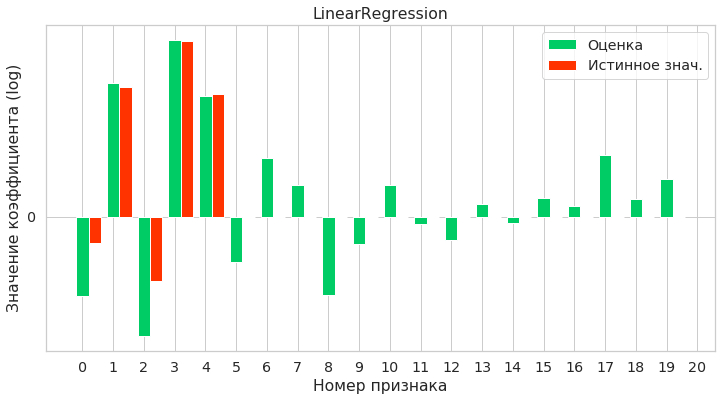

In [ ]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y.ravel())
draw_coef_bar(theta.ravel(), model.coef_, 'LinearRegression')

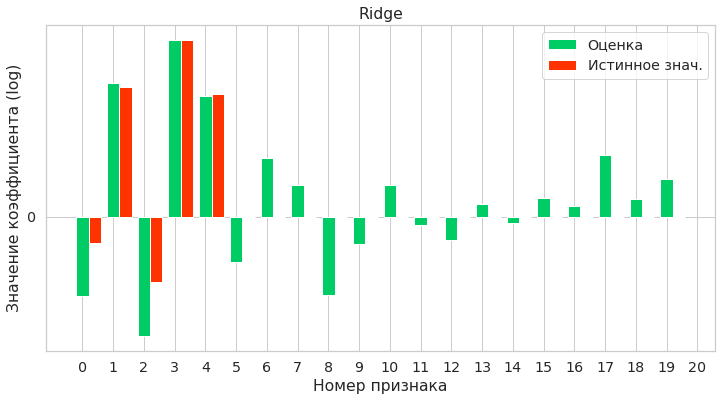

In [ ]:
model = Ridge(fit_intercept=False)
model.fit(X, y.ravel())
draw_coef_bar(theta.ravel(), model.coef_, 'Ridge')

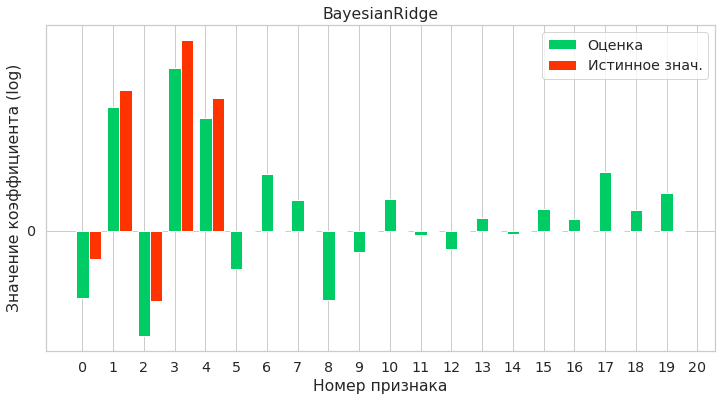

In [ ]:
model = BayesianRidge(fit_intercept=False)
model.fit(X, y.ravel())
draw_coef_bar(theta.ravel(), model.coef_, 'BayesianRidge')

CPU times: user 1min 33s, sys: 19.2 s, total: 1min 52s
Wall time: 39.8 s


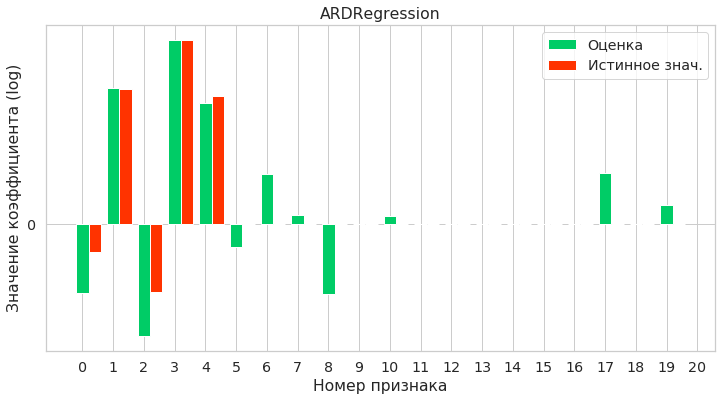

In [ ]:
%%time
model = ARDRegression(threshold_lambda=1000)
model.fit(X, y.ravel())
draw_coef_bar(theta.ravel(), model.coef_, 'ARDRegression')

Как видим, ARD-регрессия зануляет большинство незначимых признаков. В отличии от Lasso-регрессии, которая обладает похожим свойством, ARD-регрессия позволяет получить апостериорное распределение и, как следствие, проводить полноценную аналитику.